# Credit Card Approvals

In [1]:
# %%capture
# !pip install category_encoders
# !pip install hypergbm
# !pip install catboost

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import category_encoders as ce
import matplotlib.pyplot as plt 
from hypergbm import make_experiment
from category_encoders import TargetEncoder
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from hypernets.core.search_space import HyperSpace, Choice, Int, Real
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score, classification_report, precision_recall_curve, mean_absolute_percentage_error



# Load the dataset
df = pd.read_csv("clean_dataset.csv")

# Check for missing values
print("Missing values per column:\n", df.isna().sum())

df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

/usr/local/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Missing values per column:
 Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
Industry          0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
Approved          0
dtype: int64


In [3]:
df.head()

,gender,age,debt,married,bankcustomer,industry,ethnicity,yearsemployed,priordefault,employed,creditscore,driverslicense,citizen,zipcode,income,approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


# Preprocessing

### Handling NAs and Duplication

In [4]:
# Drop columns with unique values equal to the number of observations
df_unique = df.nunique().sort_values(ascending=False)
drop_cols = df_unique[df_unique.values == df.shape[0]].index.tolist()
df = df.drop(columns=drop_cols)
print("Dropped columns with unique values:", drop_cols)

# Check for duplicate observations and drop them
num_duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print("Number of duplicates after dropping:", df.duplicated().sum())

Dropped columns with unique values: []
Number of duplicates after dropping: 0


### Label Encoding

In [5]:
# Encode the target variable
le = LabelEncoder()
df["approved"] = le.fit_transform(df["approved"])

# Define target and features
X = df.drop("approved", axis=1)
y = df["approved"]


### Train-Test split

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Target Encoding

In [7]:
# Identify categorical features for target encoding
target_encode_features = ["industry", "ethnicity","citizen"]

# Apply target encoding to categorical features
target_encoder = TargetEncoder(cols=target_encode_features)
X_train[target_encode_features] = target_encoder.fit_transform(X_train[target_encode_features], y_train)
X_test[target_encode_features] = target_encoder.transform(X_test[target_encode_features])


# Apply LabelEncoder to binary categorical features
binary_categorical_features = ["gender", "married", "bankcustomer", "employed", "driverslicense"]
le = LabelEncoder()
for feature in binary_categorical_features:
    X_train[feature] = le.fit_transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])

### Correlation 

In [8]:
# Calculate correlation matrix
# Apply mask to keep only the upper triangle (exclude the diagonal as well)
# Flatten the matrix and mask to pairs and their correlations
# Filter for highly correlated pairs (e.g., |correlation| > 0.8)
corr_threshold = 0.8
corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
col_freq = highly_corr_pairs['level_0'].value_counts()
cols_drop = col_freq[col_freq.values > 1].index.tolist()
print(cols_drop)
if cols_drop:
    X_train = X_train.drop(cols_drop, axis=1)
    X_test = X_test.drop(cols_drop, axis=1)

corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
cols_drop = highly_corr_pairs['level_1'].tolist()
if cols_drop:
    X_train = X_train.drop(cols_drop, axis=1)
    X_test = X_test.drop(cols_drop, axis=1)
print(cols_drop)

[]
['bankcustomer']


# Prediction

05-17 12:23:57 W hypernets.d.__init__.py 14 - Failed to load GrpcProcess
Traceback (most recent call last):
  File "/usr/local/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/hypernets/dispatchers/process/__init__.py", line 6, in <module>
    from .grpc_process import GrpcProcess
  File "/usr/local/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/hypernets/dispatchers/process/grpc_process.py", line 6, in <module>
    from hypernets.dispatchers.process.grpc.process_broker_client import ProcessBrokerClient
  File "/usr/local/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/hypernets/dispatchers/process/grpc/process_broker_client.py", line 6, in <module>
    from hypernets.dispatchers.process.grpc.proto import proc_pb2_grpc
  File "/usr/local/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/hypernets/dispatchers/process/grpc/proto/proc_pb2_grpc.py", line 4, in <module>
    from hypernets.dispatchers.process.grpc.proto import proc_pb2 as hyp

### Input Data

,X_train.shape,y_train.shape,X_eval.shape,y_eval.shape,X_test.shape,Task
0,"(552, 14)","(552,)","(138, 14)","(138,)",None,binary(2)


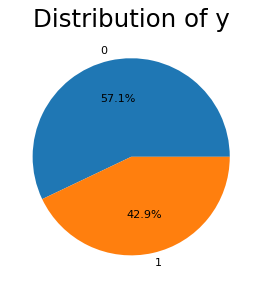

## Data Adaption

### Initliazed parameters

,key,value
0,memory_limit,0.05
1,min_cols,0.3
2,name,data_adaption
3,target,None


### Fitted parameters

,key,value
0,input_features,"[gender, age, debt, married, industry, ethnici..."
1,selected_features,"[gender, age, debt, married, industry, ethnici..."
2,unselected_features,[]


### Elapsed

* 0.008 seconds

## Data Clean

### Initliazed parameters

,key,value
0,cv,False
1,data_cleaner_args,"{'nan_chars': None, 'correct_object_dtype': Tr..."
2,name,data_clean
3,train_test_split_strategy,None


### Fitted parameters

,key,value
0,input_features,"[gender, age, debt, married, industry, ethnici..."
1,selected_features,"[gender, age, debt, married, industry, ethnici..."
2,unselected_features,[]
3,X_train.shape,"(552, 14)"
4,y_train.shape,"(552,)"
5,X_eval.shape,"(138, 14)"
6,y_eval.shape,"(138,)"
7,X_test.shape,None
8,unselected_reason,{}
9,kept/dropped feature count,14/0


### Elapsed

* 0.037 seconds

## Space Searching

### Initliazed parameters

,key,value
0,cv,False
1,name,space_searching
2,num_folds,3


#### Experiment Settings:

HyperGBM(searcher=EvolutionSearcher(space_fn=GeneralSearchSpaceGenerator(kwargs=None, n_estimators=200, verbose=2), population_size=30, sample_size=10, regularized=True, optimize_direction='max', random_state=RandomState(MT19937) at 0x12F4F7E40), callbacks=[EarlyStoppingCallback(max_no_improvement_trials=10, mode='max', time_limit=3599.9527337551117), NotebookCallback(), ProgressiveCallback(), FitCrossValidationCallback()], reward_metric='auc', task='binary', discriminator=OncePercentileDiscriminator(percentile=50, history=TrialHistory(direction='max'), optimize_direction='max'))

,X,y,X_eval,y_eval,cv,num_folds,max_trials,fit_kwargs
0,"(552, 14)","(552,)","(138, 14)","(138,)",False,3,20,"(verbose, eval_set)"


#### Trials Summary:

,Trial No.,Previous reward,Best trial,Best reward,Total elapsed,Valid trials,Max trials
0,20,0.920168,16,[0.9372899159663866],10.173392,20,20


#### Best Trial:

key,value
signature,07eb114c3cebfac1fa1af984886326ec
vectors,"[2, 2, 4, 3, 0, 2]"
0-estimator_options.hp_or,2
1-numeric_imputer_0.strategy,constant
2-numeric_or_scaler_0.hp_or,4
3-Module_CatBoostEstimator_1.learning_rate,0.1
4-Module_CatBoostEstimator_1.depth,3
5-Module_CatBoostEstimator_1.l2_leaf_reg,10


#### Top trials:

,Trial No.,Reward,Elapsed,Space Vector
0,16,[0.9372899159663866],0.373872,"[2, 2, 4, 3, 0, 2]"
1,10,[0.9213235294117648],0.372548,"[1, 0, 3, 3, 3, 4, 0, 4, 4]"
2,1,[0.921218487394958],0.408435,"[2, 2, 4, 0, 2, 1]"
3,15,[0.9205882352941177],0.346407,"[1, 3, 4, 2, 2, 0, 0, 3, 4]"
4,20,[0.9201680672268907],0.385564,"[0, 2, 1, 2, 330, 1, 3, 0, 3]"


### Fitted parameters

,key,value
0,input_features,"[gender, age, debt, married, industry, ethnici..."
1,best_reward,[0.9372899159663866]
2,history,"TrialHistory(direction='max', size=20, succeed..."


### Elapsed

* 10.219 seconds

## Final Ensemble

### Initliazed parameters

,key,value
0,ensemble_size,20
1,name,final_ensemble
2,scorer,"make_scorer(roc_auc_score, response_method='pr..."


### Fitted parameters

,0,1
0,weights,"[0.25, 0.05, 0.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1,scores,"[0.9372899159663866, 0.9378151260504202, 0.938..."
2,best_stack,"[0, 2, 13, 12, 12, 12, 0, 2, 2, 12, 0, 2, 2, 0..."
3,hits,"{0: 5, 2: 7, 13: 1, 12: 5, 1: 1, 10: 1}"
4,ensemble_size,20


### Elapsed

* 4.972 seconds

In [9]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Create and run a HyperGBM experiment with hyperparameter tuning
experiment = make_experiment(train_data,
                             target='approved',
                             eval_data=test_data,
                             max_trials=20,
                             reward_metric='auc',
                             random_state=42,verbose=2)

hyper_model = experiment.run()

y_train_pred = hyper_model.predict_proba(X_train)[:, 1]
y_test_pred = hyper_model.predict_proba(X_test)[:, 1]

In [10]:
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

0.9609269305471838
0.9380252100840336


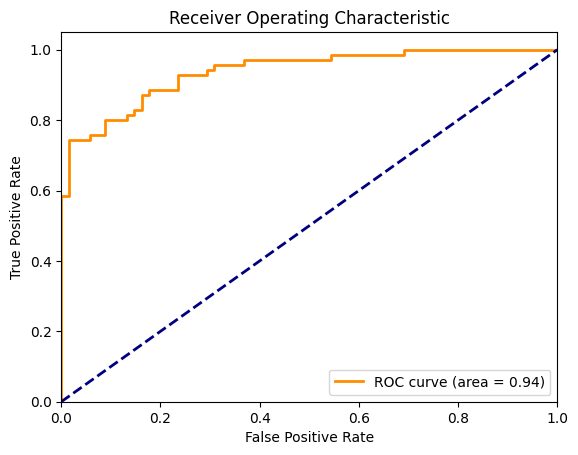

In [11]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Other Models for Experiment

## Logistic Regression

In [12]:
df_lg = pd.read_csv("clean_dataset.csv")
df_lg.columns = df_lg.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

vc = df_lg["zipcode"].value_counts()
df_lg.loc[df_lg.zipcode != 0, "zipcode"] = 1
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']
df_lg['age'] = pd.cut(df_lg['age'], bins=bins, labels=labels, right=False)

age_group_encoder = OrdinalEncoder()
df_lg['age'] = age_group_encoder.fit_transform(df_lg[['age']])

# Drop columns with unique values equal to the number of observations
df_unique = df_lg.nunique().sort_values(ascending=False)
drop_cols = df_unique[df_unique.values == df_lg.shape[0]].index.tolist()
df_lg = df_lg.drop(columns=drop_cols)

# Check for duplicate observations and drop them
num_duplicates = df_lg.duplicated().sum()
df_lg = df_lg.drop_duplicates()
# Encode the target variable
le = LabelEncoder()
df_lg["approved"] = le.fit_transform(df_lg["approved"])

# Define target and features
X_lg = df_lg.drop("approved", axis=1)
y_lg = df_lg["approved"]

# Split the dataset into training and testing sets
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X_lg, y_lg, test_size=0.2, random_state=42)


# Identify categorical features for target encoding
target_encode_features = ["industry", "ethnicity", "citizen"]

# Apply target encoding to categorical features
target_encoder = TargetEncoder(cols=target_encode_features)
X_train_lg[target_encode_features] = target_encoder.fit_transform(X_train_lg[target_encode_features], y_train_lg)
X_test_lg[target_encode_features] = target_encoder.transform(X_test_lg[target_encode_features])


# Apply LabelEncoder to binary categorical features
binary_categorical_features = ["gender", "married", "bankcustomer", "employed", "driverslicense"]
le = LabelEncoder()
for feature in binary_categorical_features:
    X_train_lg[feature] = le.fit_transform(X_train_lg[feature])
    X_test_lg[feature] = le.transform(X_test_lg[feature])


# Calculate correlation matrix
# Apply mask to keep only the upper triangle (exclude the diagonal as well)
# Flatten the matrix and mask to pairs and their correlations
# Filter for highly correlated pairs (e.g., |correlation| > 0.8)
corr_threshold = 0.8
corr_matrix = X_train_lg.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
col_freq = highly_corr_pairs['level_0'].value_counts()
cols_drop = col_freq[col_freq.values > 1].index.tolist()
print(cols_drop)
if cols_drop:
    X_train_lg = X_train_lg.drop(cols_drop, axis=1)
    X_test_lg = X_test_lg.drop(cols_drop, axis=1)

corr_matrix = X_train_lg.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
cols_drop = highly_corr_pairs['level_1'].tolist()
if cols_drop:
    X_train_lg = X_train_lg.drop(cols_drop, axis=1)
    X_test_lg = X_test_lg.drop(cols_drop, axis=1)
print(cols_drop)

# Standardize the features for logistic regression
logistic_scaler = StandardScaler()
X_train_scaled_lg = logistic_scaler.fit_transform(X_train_lg)
X_train_scaled_lg = pd.DataFrame(X_train_scaled_lg, columns=X_train_lg.columns)

X_test_scaled_lg = logistic_scaler.transform(X_test_lg)
X_test_scaled_lg = pd.DataFrame(X_test_scaled_lg, columns=X_test_lg.columns)


[]
['bankcustomer']


In [13]:

# GridSearch
logistic_param_grid = {
    'C': [0.001, 0.05, 0.1, 0.2, 0.3, 1],  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [1000, 10000, None],
    'fit_intercept': [True, False],
    'class_weight': ['balanced']
}

logistic_model = LogisticRegression()
# Configure and run the grid search
logistic_grid_search = GridSearchCV(logistic_model, logistic_param_grid, cv=5, verbose=1, n_jobs=-1, scoring="roc_auc")
logistic_grid_search.fit(X_train_scaled_lg, y_train_lg)

print(logistic_grid_search.best_params_)
logistic_grid_search.best_params_["C"] = 0.05
print(logistic_grid_search.best_params_)
# Run logistic regression with the best parameters
logistic_model = LogisticRegression(random_state=42, **logistic_grid_search.best_params_)
logistic_model.fit(X_train_scaled_lg, y_train_lg)

train_probs = logistic_model.predict_proba(X_train_scaled_lg)[:, 1]  # Probabilities for the training set
test_probs = logistic_model.predict_proba(X_test_scaled_lg)[:, 1]    # Probabilities for the testing set




Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'C': 1, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
{'C': 0.05, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


In [14]:
# Calculate ROC AUC scores
logistic_train_auc = roc_auc_score(y_train_lg, train_probs)
logistic_test_auc = roc_auc_score(y_test_lg, test_probs)
print("Train AUC:", round(logistic_train_auc, 3))
print("Test AUC:", round(logistic_test_auc, 3))


Train AUC: 0.939
Test AUC: 0.912


In [15]:
coefs_ = pd.DataFrame({"columns_":X_train_scaled_lg.columns, "coefs":logistic_model.coef_[0]}).sort_values("coefs",ascending=False)
coefs_.reset_index(drop=True)

,columns_,coefs
0,priordefault,1.403645
1,industry,0.347745
2,creditscore,0.230404
3,employed,0.199006
4,income,0.151257
5,age,0.007591
6,ethnicity,0.000000
7,married,0.000000
8,debt,0.000000
9,gender,0.000000


## Random Forest 

In [16]:
# Data processing for randomforest hypergbm
df_rf = pd.read_csv("clean_dataset.csv")

df_rf.columns = df_rf.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Drop columns with unique values equal to the number of observations
df_rf_unique = df_rf.nunique().sort_values(ascending=False)
drop_cols = df_rf_unique[df_rf_unique.values == df_rf.shape[0]].index.tolist()
df_rf = df_rf.drop(columns=drop_cols)
print("Dropped columns with unique values:", drop_cols)


df_rf.loc[df_rf.zipcode!=0,"zipcode"] = 1

# Encode the target variable
le = LabelEncoder()
df_rf["approved"] = le.fit_transform(df_rf["approved"])

# Define target and features
X_rf = df_rf.drop("approved", axis=1)
y_rf = df_rf["approved"]


# Split the dataset into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Identify categorical features for target encoding
target_encode_features_rf = ["industry", "ethnicity","citizen"]

# Apply target encoding to categorical features
target_encoder_rf = TargetEncoder(cols=target_encode_features_rf)
X_train_rf[target_encode_features] = target_encoder_rf.fit_transform(X_train_rf[target_encode_features_rf], y_train_rf)
X_test_rf[target_encode_features] = target_encoder_rf.transform(X_test_rf[target_encode_features_rf])

# Apply LabelEncoder to binary categorical features
binary_categorical_features_rf = ["gender", "married", "bankcustomer", "employed", "driverslicense"]
le = LabelEncoder()
for feature in binary_categorical_features_rf:
    X_train_rf[feature] = le.fit_transform(X_train_rf[feature])
    X_test_rf[feature] = le.transform(X_test_rf[feature])


# Calculate correlation matrix
# Apply mask to keep only the upper triangle (exclude the diagonal as well)
# Flatten the matrix and mask to pairs and their correlations
# Filter for highly correlated pairs (e.g., |correlation| > 0.8)
corr_threshold = 0.8
corr_matrix = X_train_rf.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
col_freq = highly_corr_pairs['level_0'].value_counts()
cols_drop = col_freq[col_freq.values > 1].index.tolist()
if cols_drop:
    X_train_rf = X_train_rf.drop(cols_drop, axis=1)
    X_test_rf = X_test_rf.drop(cols_drop, axis=1)

corr_matrix = X_train_rf.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
cols_drop = highly_corr_pairs['level_1'].tolist()
if cols_drop:
    X_train_rf = X_train_rf.drop(cols_drop, axis=1)
    X_test_rf = X_test_rf.drop(cols_drop, axis=1)

Dropped columns with unique values: []


In [17]:
rf_model = RandomForestClassifier(random_state=23, class_weight='balanced')

# Set up the parameter grid
dt_param_grid = {
    'n_estimators':[40],# [10,30,50],#300
    'max_depth': [1]
}

#[10,20]
    # 'max_features': ['auto', 'sqrt', 'log2']
# Set up GridSearchCV
gs_dt = GridSearchCV(rf_model, param_grid=dt_param_grid, scoring='roc_auc')

# Fit GridSearchCV
gs_dt.fit(X_train_rf, y_train_rf)

# Access the best estimator
best_dt_estimator = gs_dt.best_estimator_
print("Best estimator:", best_dt_estimator)

# Make predictions
y_train_predicted = best_dt_estimator.predict(X_train_rf)
y_test_predicted = best_dt_estimator.predict(X_test_rf)

# Calculate and print AUC scores
train_probs = best_dt_estimator.predict_proba(X_train_rf)[:, 1]
test_probs = best_dt_estimator.predict_proba(X_test_rf)[:, 1]

train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_test, test_probs)

print("Training AUC:", train_auc)
print("Testing AUC:", test_auc)

Best estimator: RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=40,
                       random_state=23)
Training AUC: 0.9334003080838523
Testing AUC: 0.9038865546218487


In [18]:
# Get feature importances and create DataFrame
feature_names = X_train.columns
feature_importances = best_dt_estimator.feature_importances_
coefs_ = pd.DataFrame({"columns_": feature_names, "importances": feature_importances}).sort_values("importances", ascending=False)
coefs_ = coefs_.reset_index(drop=True)
coefs_

,columns_,importances
0,industry,0.175
1,priordefault,0.175
2,income,0.150
3,creditscore,0.150
4,yearsemployed,0.150
5,employed,0.125
6,debt,0.050
7,married,0.025
8,gender,0.000
9,age,0.000


## Catboost

In [19]:
df_cb = pd.read_csv("clean_dataset.csv")

# Clean column names
df_cb.columns = df_cb.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Drop columns with unique values equal to the number of observations
df_cb_unique = df_cb.nunique().sort_values(ascending=False)
df_cb_drop_cols = df_cb_unique[df_cb_unique.values == df_cb.shape[0]].index.tolist()
df_cb = df_cb.drop(columns=df_cb_drop_cols)
print("Dropped columns with unique values:", df_cb_drop_cols)

# Check for duplicate observations and drop them
df_cb_num_duplicates = df_cb.duplicated().sum()
df_cb = df_cb.drop_duplicates()
print("Number of duplicates after dropping:", df_cb.duplicated().sum())

# Simplify zipcode for this example
df_cb_vc = df_cb["zipcode"].value_counts()
df_cb.loc[df_cb.zipcode != 0, "zipcode"] = 1

# Encode the target variable
df_cb_le = LabelEncoder()
df_cb["approved"] = df_cb_le.fit_transform(df_cb["approved"])

# Define target and features
df_cb_X = df_cb.drop("approved", axis=1)
df_cb_y = df_cb["approved"]

# Split the dataset into training and testing sets
df_cb_X_train, df_cb_X_test, df_cb_y_train, df_cb_y_test = train_test_split(df_cb_X, df_cb_y, test_size=0.2, random_state=42)

# Apply LabelEncoder to binary categorical features
df_cb_binary_categorical_features = ["gender", "married", "bankcustomer", "employed", "driverslicense"]
df_cb_le = LabelEncoder()
for feature in df_cb_binary_categorical_features:
    df_cb_X_train[feature] = df_cb_le.fit_transform(df_cb_X_train[feature])
    df_cb_X_test[feature] = df_cb_le.transform(df_cb_X_test[feature])


Dropped columns with unique values: []
Number of duplicates after dropping: 0


In [20]:
# Define categorical features for CatBoost
from catboost import CatBoostClassifier, Pool
df_cb_cat_features = ["gender", "married", "industry", "ethnicity", "employed", "driverslicense", "citizen", "zipcode"]

# Create CatBoost Pool for training and testing
df_cb_train_pool = Pool(data=df_cb_X_train, label=df_cb_y_train, cat_features=df_cb_cat_features)
df_cb_test_pool = Pool(data=df_cb_X_test, label=df_cb_y_test, cat_features=df_cb_cat_features)

# Initialize and train the CatBoost classifier
df_cb_catboost_model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.01,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

df_cb_catboost_model.fit(df_cb_train_pool, eval_set=df_cb_test_pool, early_stopping_rounds=50)

df_cb_y_train_pred_proba = df_cb_catboost_model.predict_proba(df_cb_X_train)[:, 1]
df_cb_train_roc_auc = roc_auc_score(df_cb_y_train, df_cb_y_train_pred_proba)

# Compute ROC AUC for testing set
df_cb_y_test_pred_proba = df_cb_catboost_model.predict_proba(df_cb_X_test)[:, 1]
df_cb_test_roc_auc = roc_auc_score(df_cb_y_test, df_cb_y_test_pred_proba)

print(f"Train ROC AUC Score: {df_cb_train_roc_auc:.4f}")
print(f"Test ROC AUC Score: {df_cb_test_roc_auc:.4f}")


0:	learn: 0.8659420	test: 0.8260870	best: 0.8260870 (0)	total: 6.73ms	remaining: 4.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8333333333
bestIteration = 3

Shrink model to first 4 iterations.
Train ROC AUC Score: 0.9515
Test ROC AUC Score: 0.9251


In [21]:
# Get feature importances and create DataFrame
df_cb_feature_names = df_cb_X_train.columns
df_cb_feature_importances = df_cb_catboost_model.feature_importances_
df_cb_coefs_ = pd.DataFrame({"columns_": df_cb_feature_names, "importances": df_cb_feature_importances}).sort_values("importances", ascending=False)
df_cb_coefs_ = coefs_.reset_index(drop=True)

df_cb_coefs_

,columns_,importances
0,industry,0.175
1,priordefault,0.175
2,income,0.150
3,creditscore,0.150
4,yearsemployed,0.150
5,employed,0.125
6,debt,0.050
7,married,0.025
8,gender,0.000
9,age,0.000


## XGBoost

In [22]:

# Load the dataset
df_xgb = pd.read_csv("clean_dataset.csv")

# Preprocess column names
df_xgb.columns = df_xgb.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Drop columns with unique values equal to the number of observations
df_xgb_unique = df_xgb.nunique().sort_values(ascending=False)
drop_cols = df_xgb_unique[df_xgb_unique.values == df_xgb.shape[0]].index.tolist()
df_xgb = df_xgb.drop(columns=drop_cols)

# Simplify zipcode feature
df_xgb.loc[df_xgb.zipcode != 0, "zipcode"] = 1

# Encode the target variable
le = LabelEncoder()
df_xgb["approved"] = le.fit_transform(df_xgb["approved"])

# Define target and features
X_xgb = df_xgb.drop("approved", axis=1)
y_xgb = df_xgb["approved"]

# Split the dataset into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

# Identify categorical features for target encoding
target_encode_features_xgb = ["industry", "ethnicity", "citizen"]

# Apply target encoding to categorical features
target_encoder_xgb = TargetEncoder(cols=target_encode_features_xgb)
X_train_xgb[target_encode_features_xgb] = target_encoder_xgb.fit_transform(X_train_xgb[target_encode_features_xgb], y_train_xgb)
X_test_xgb[target_encode_features_xgb] = target_encoder_xgb.transform(X_test_xgb[target_encode_features_xgb])

# Apply LabelEncoder to binary categorical features
binary_categorical_features_xgb = ["gender", "married", "bankcustomer", "employed", "driverslicense"]
le = LabelEncoder()
for feature in binary_categorical_features_xgb:
    X_train_xgb[feature] = le.fit_transform(X_train_xgb[feature])
    X_test_xgb[feature] = le.transform(X_test_xgb[feature])

# Calculate correlation matrix and drop highly correlated features
corr_threshold = 0.8
corr_matrix = X_train_xgb.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
col_freq = highly_corr_pairs['level_0'].value_counts()
cols_drop = col_freq[col_freq.values > 1].index.tolist()
if cols_drop:
    X_train_xgb = X_train_xgb.drop(cols_drop, axis=1)
    X_test_xgb = X_test_xgb.drop(cols_drop, axis=1)

corr_matrix = X_train_xgb.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_pairs = corr_matrix.where(mask).stack()
highly_corr_pairs = corr_pairs[abs(corr_pairs) > corr_threshold].reset_index()
cols_drop = highly_corr_pairs['level_1'].tolist()
if cols_drop:
    X_train_xgb = X_train_xgb.drop(cols_drop, axis=1)
    X_test_xgb = X_test_xgb.drop(cols_drop, axis=1)


In [23]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up the parameter grid for GridSearchCV
xgb_param_grid = {
    'n_estimators': [30],
    'max_depth': [1],
    'learning_rate': [0.1],
    'gamma': [0.01],  # Regularization parameter
    'lambda': [ 0.3],   # L2 regularization term
    'alpha': [ 0.5]    # L1 regularization term
}


# Set up GridSearchCV
gs_xgb = GridSearchCV(xgb_model, param_grid=xgb_param_grid, scoring='roc_auc', cv=3)

# Fit GridSearchCV
gs_xgb.fit(X_train_xgb, y_train_xgb)

# Access the best estimator
best_xgb_estimator = gs_xgb.best_estimator_
print("Best estimator:", best_xgb_estimator)

# Make predictions
y_train_predicted = best_xgb_estimator.predict(X_train_xgb)
y_test_predicted = best_xgb_estimator.predict(X_test_xgb)

train_probs = best_xgb_estimator.predict_proba(X_train_xgb)[:, 1]
test_probs = best_xgb_estimator.predict_proba(X_test_xgb)[:, 1]

train_auc = roc_auc_score(y_train_xgb, train_probs)
test_auc = roc_auc_score(y_test_xgb, test_probs)

print("Training AUC:", train_auc)
print("Testing AUC:", test_auc)

Best estimator: XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.01, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.3,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, ...)
Training AUC: 0.9429308150827138
Testing AUC: 0.9101890756302521
